In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 한글 폰트 설정 (Mac의 경우)
mpl.rc('font', family='AppleGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 파라미터
SEED = 42
WINDOW = 7
EPOCHS = 30
LR = 1e-3
LAMBDA_EWC = 100

torch.manual_seed(SEED)
np.random.seed(SEED)

# 전처리
df = pd.read_csv("onion_separated.csv")
df = df[df['rate'] == 'HIGH'].copy()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[df['month'].isin([4, 5])].sort_values('date').reset_index(drop=True)

df['prev_price'] = df['avg_price'].shift(1)
df['price_diff'] = df['avg_price'] - df['prev_price']
df['rolling_mean'] = df['avg_price'].rolling(window=3).mean()
df['rolling_std'] = df['avg_price'].rolling(window=3).std()
df = df.dropna()
df['log_price'] = np.log1p(df['avg_price'])

feature_cols = ['intake', 'gap', 'price_diff', 'rolling_mean', 'rolling_std']
target_col = 'log_price'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[feature_cols] = scaler_x.fit_transform(df[feature_cols])
df[[target_col]] = scaler_y.fit_transform(df[[target_col]])

X_seq, y_seq, dates = [], [], []
for i in range(len(df) - WINDOW):
    window = df.iloc[i:i+WINDOW]
    target = df.iloc[i+WINDOW]
    X_seq.append(window[feature_cols].values)
    y_seq.append(target[target_col])
    dates.append(target['date'])

X_seq = torch.tensor(np.array(X_seq), dtype=torch.float32)
y_seq = torch.tensor(np.array(y_seq), dtype=torch.float32)
cutoff = pd.to_datetime("2025-05-13")

# LSTM 모델
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# EWC 클래스
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.criterion = criterion
        self.dataloader = dataloader
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for x, y in self.dataloader:
            self.model.zero_grad()
            out = self.model(x)
            loss = self.criterion(out.squeeze(-1), y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    precision[n] += p.grad.data.pow(2)
        return {n: p / len(self.dataloader) for n, p in precision.items()}

    def penalty(self, model):
        return sum(
            (self._precision_matrices[n] * (p - self.params[n]).pow(2)).sum()
            for n, p in model.named_parameters() if p.requires_grad
        )

# 첫 학습
model = LSTMModel(input_size=len(feature_cols))
optimizer = AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()

init_idx = [i for i, d in enumerate(dates) if d <= cutoff]
X_init, y_init = X_seq[init_idx], y_seq[init_idx]
init_loader = DataLoader(TensorDataset(X_init, y_init), batch_size=16, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    for x, y in init_loader:
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(-1), y)
        loss.backward()
        optimizer.step()

ewc_list = [EWC(model, init_loader, criterion)]

# 지속 학습
for i in range(len(X_seq)):
    if dates[i] <= cutoff:
        continue

    X_batch = X_seq[i].unsqueeze(0)
    y_batch = y_seq[i].unsqueeze(0)
    loader = DataLoader(TensorDataset(X_batch, y_batch), batch_size=1)

    model.train()
    for epoch in range(EPOCHS):
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out.squeeze(-1), y)
            for ewc in ewc_list:
                loss += LAMBDA_EWC * ewc.penalty(model)
            loss.backward()
            optimizer.step()

    ewc_list.append(EWC(model, loader, criterion))

    model.eval()
    with torch.no_grad():
        pred = model(X_batch).item()
        real = y_batch.item()
        pred_rescaled = np.expm1(scaler_y.inverse_transform([[pred]])[0][0])
        real_rescaled = np.expm1(scaler_y.inverse_transform([[real]])[0][0])
        print(f"[{dates[i].date()}] 예측가: {pred_rescaled:.2f}원, 실제가: {real_rescaled:.2f}원")


[2025-05-14] 예측가: 828.69원, 실제가: 770.00원
[2025-05-15] 예측가: 775.46원, 실제가: 788.00원
[2025-05-16] 예측가: 730.99원, 실제가: 750.00원
[2025-05-17] 예측가: 754.89원, 실제가: 741.00원
[2025-05-19] 예측가: 761.46원, 실제가: 754.00원
[2025-05-20] 예측가: 727.13원, 실제가: 728.00원


/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_24104/2214393054.py:158: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_24104/2214393054.py:158: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_24104/2214393054.py:158: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.tight_layout()
/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_24104/2214393054.py:158: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  plt.tight_layout()
/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_24104/2214393054.py:158: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
/var/folders/mc/npy4915s0gqclqt2wqx1vygm0000gn/T/ipykernel_24104/2214393054.py:158:

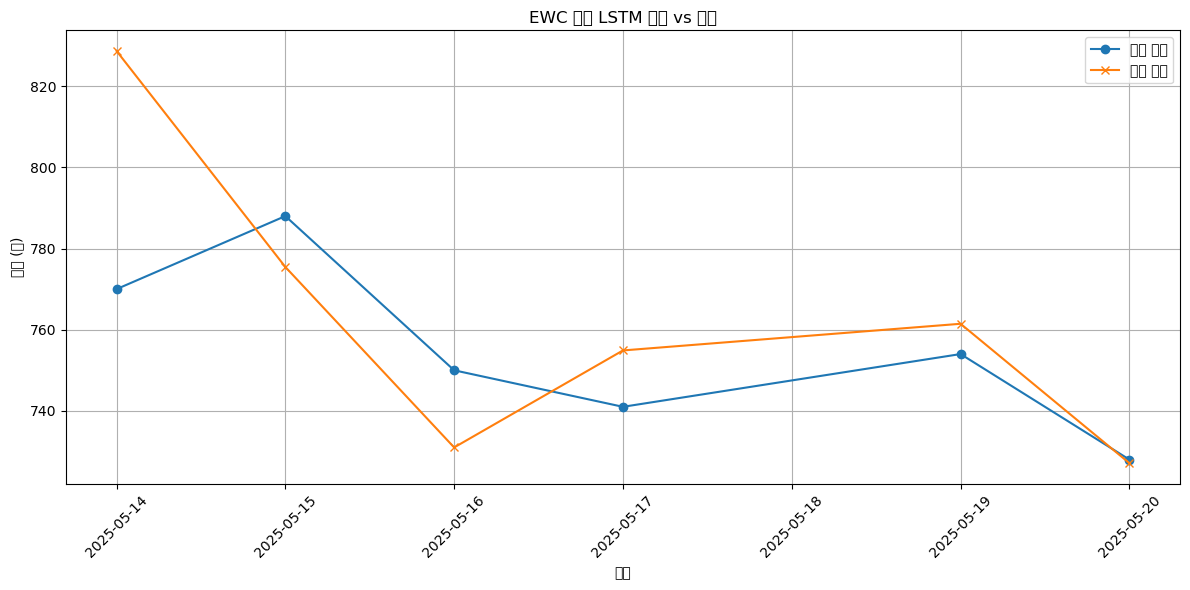

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 파라미터
SEED = 42
WINDOW = 7
EPOCHS = 30
LR = 1e-3
LAMBDA_EWC = 100

torch.manual_seed(SEED)
np.random.seed(SEED)

# 데이터 불러오기 및 전처리
df = pd.read_csv("onion_separated.csv")
df = df[df['rate'] == 'HIGH'].copy()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[df['month'].isin([4, 5])].sort_values('date').reset_index(drop=True)

df['prev_price'] = df['avg_price'].shift(1)
df['price_diff'] = df['avg_price'] - df['prev_price']
df['rolling_mean'] = df['avg_price'].rolling(window=3).mean()
df['rolling_std'] = df['avg_price'].rolling(window=3).std()
df = df.dropna()
df['log_price'] = np.log1p(df['avg_price'])

feature_cols = ['intake', 'gap', 'price_diff', 'rolling_mean', 'rolling_std']
target_col = 'log_price'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[feature_cols] = scaler_x.fit_transform(df[feature_cols])
df[[target_col]] = scaler_y.fit_transform(df[[target_col]])

X_seq, y_seq, dates = [], [], []
for i in range(len(df) - WINDOW):
    window = df.iloc[i:i+WINDOW]
    target = df.iloc[i+WINDOW]
    X_seq.append(window[feature_cols].values)
    y_seq.append(target[target_col])
    dates.append(target['date'])

X_seq = torch.tensor(np.array(X_seq), dtype=torch.float32)
y_seq = torch.tensor(np.array(y_seq), dtype=torch.float32)
cutoff = pd.to_datetime("2025-05-13")

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# EWC 클래스 정의
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.criterion = criterion
        self.dataloader = dataloader
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for x, y in self.dataloader:
            self.model.zero_grad()
            out = self.model(x)
            loss = self.criterion(out.squeeze(-1), y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    precision[n] += p.grad.data.pow(2)
        return {n: p / len(self.dataloader) for n, p in precision.items()}

    def penalty(self, model):
        return sum(
            (self._precision_matrices[n] * (p - self.params[n]).pow(2)).sum()
            for n, p in model.named_parameters() if p.requires_grad
        )

# 첫 학습
model = LSTMModel(input_size=len(feature_cols))
optimizer = AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()

init_idx = [i for i, d in enumerate(dates) if d <= cutoff]
X_init, y_init = X_seq[init_idx], y_seq[init_idx]
init_loader = DataLoader(TensorDataset(X_init, y_init), batch_size=16, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    for x, y in init_loader:
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(-1), y)
        loss.backward()
        optimizer.step()

ewc_list = [EWC(model, init_loader, criterion)]

# 지속 학습 및 시각화를 위한 결과 저장
predictions = []
real_values = []
predict_dates = []

for i in range(len(X_seq)):
    if dates[i] <= cutoff:
        continue

    X_batch = X_seq[i].unsqueeze(0)
    y_batch = y_seq[i].unsqueeze(0)
    loader = DataLoader(TensorDataset(X_batch, y_batch), batch_size=1)

    model.train()
    for epoch in range(EPOCHS):
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out.squeeze(-1), y)
            for ewc in ewc_list:
                loss += LAMBDA_EWC * ewc.penalty(model)
            loss.backward()
            optimizer.step()

    ewc_list.append(EWC(model, loader, criterion))

    model.eval()
    with torch.no_grad():
        pred = model(X_batch).item()
        real = y_batch.item()
        pred_rescaled = np.expm1(scaler_y.inverse_transform([[pred]])[0][0])
        real_rescaled = np.expm1(scaler_y.inverse_transform([[real]])[0][0])
        predictions.append(pred_rescaled)
        real_values.append(real_rescaled)
        predict_dates.append(dates[i])

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(predict_dates, real_values, label='실제 가격', marker='o')
plt.plot(predict_dates, predictions, label='예측 가격', marker='x')
plt.title('EWC 기반 LSTM 예측 vs 실제')
plt.xlabel('날짜')
plt.ylabel('가격 (원)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


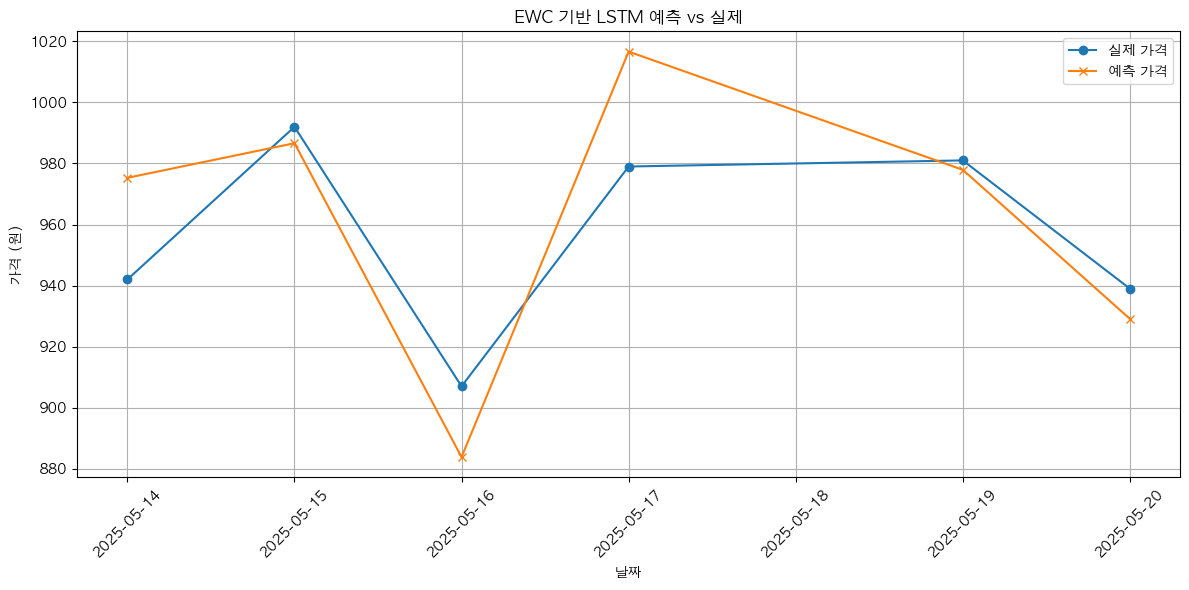

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 파라미터
SEED = 42
WINDOW = 7
EPOCHS = 30
LR = 1e-3
LAMBDA_EWC = 100

torch.manual_seed(SEED)
np.random.seed(SEED)

# 데이터 불러오기 및 전처리
df = pd.read_csv("onion_separated.csv")
df = df[df['rate'] == 'Special'].copy()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[df['month'].isin([4, 5])].sort_values('date').reset_index(drop=True)

df['prev_price'] = df['avg_price'].shift(1)
df['price_diff'] = df['avg_price'] - df['prev_price']
df['rolling_mean'] = df['avg_price'].rolling(window=3).mean()
df['rolling_std'] = df['avg_price'].rolling(window=3).std()
df = df.dropna()
df['log_price'] = np.log1p(df['avg_price'])

feature_cols = ['intake', 'gap', 'price_diff', 'rolling_mean', 'rolling_std']
target_col = 'log_price'

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df[feature_cols] = scaler_x.fit_transform(df[feature_cols])
df[[target_col]] = scaler_y.fit_transform(df[[target_col]])

X_seq, y_seq, dates = [], [], []
for i in range(len(df) - WINDOW):
    window = df.iloc[i:i+WINDOW]
    target = df.iloc[i+WINDOW]
    X_seq.append(window[feature_cols].values)
    y_seq.append(target[target_col])
    dates.append(target['date'])

X_seq = torch.tensor(np.array(X_seq), dtype=torch.float32)
y_seq = torch.tensor(np.array(y_seq), dtype=torch.float32)
cutoff = pd.to_datetime("2025-05-13")

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# EWC 클래스 정의
class EWC:
    def __init__(self, model, dataloader, criterion):
        self.model = model
        self.criterion = criterion
        self.dataloader = dataloader
        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.model.eval()
        for x, y in self.dataloader:
            self.model.zero_grad()
            out = self.model(x)
            loss = self.criterion(out.squeeze(-1), y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.requires_grad:
                    precision[n] += p.grad.data.pow(2)
        return {n: p / len(self.dataloader) for n, p in precision.items()}

    def penalty(self, model):
        return sum(
            (self._precision_matrices[n] * (p - self.params[n]).pow(2)).sum()
            for n, p in model.named_parameters() if p.requires_grad
        )

# 첫 학습
model = LSTMModel(input_size=len(feature_cols))
optimizer = AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()

init_idx = [i for i, d in enumerate(dates) if d <= cutoff]
X_init, y_init = X_seq[init_idx], y_seq[init_idx]
init_loader = DataLoader(TensorDataset(X_init, y_init), batch_size=16, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    for x, y in init_loader:
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred.squeeze(-1), y)
        loss.backward()
        optimizer.step()

ewc_list = [EWC(model, init_loader, criterion)]

# 지속 학습 및 시각화를 위한 결과 저장
predictions = []
real_values = []
predict_dates = []

for i in range(len(X_seq)):
    if dates[i] <= cutoff:
        continue

    X_batch = X_seq[i].unsqueeze(0)
    y_batch = y_seq[i].unsqueeze(0)
    loader = DataLoader(TensorDataset(X_batch, y_batch), batch_size=1)

    model.train()
    for epoch in range(EPOCHS):
        for x, y in loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out.squeeze(-1), y)
            for ewc in ewc_list:
                loss += LAMBDA_EWC * ewc.penalty(model)
            loss.backward()
            optimizer.step()

    ewc_list.append(EWC(model, loader, criterion))

    model.eval()
    with torch.no_grad():
        pred = model(X_batch).item()
        real = y_batch.item()
        pred_rescaled = np.expm1(scaler_y.inverse_transform([[pred]])[0][0])
        real_rescaled = np.expm1(scaler_y.inverse_transform([[real]])[0][0])
        predictions.append(pred_rescaled)
        real_values.append(real_rescaled)
        predict_dates.append(dates[i])

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(predict_dates, real_values, label='실제 가격', marker='o')
plt.plot(predict_dates, predictions, label='예측 가격', marker='x')
plt.title('EWC 기반 LSTM 예측 vs 실제')
plt.xlabel('날짜')
plt.ylabel('가격 (원)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
